# Lab 06: Predicting Water Pump Functionality in Tanzania

## Overview: 

In this project, we apply machine learning techniques to predict the operational status of water pumps across Tanzania. Access to clean and safe water is a fundamental human right, and by identifying faulty infrastructure, we aim to support future maintenance planning.

This dataset, provided by Taarifa and the Tanzanian Ministry of Water, is made available through the [DrivenData Competition](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/). It contains features describing what kind of water pump is in operation and how it's managed. Our target variable is _status_group_, which categorizes each water pump as: 

- **functional**
- **functional needs repair**
- **non functional**

This is a multiclass classification problem, and the goal would be to train a model that can accurately predict the status of the water pump in the test set, for which the labels have not been provided.

## Tools and Approach

We will follow the rudimentary data science approach and draw concepts covered in previous labs:

- **EDA**: Understand possible trends in the distribution of classes and missing data using Pandas, Seaborn, etc.
- **Data Preparation**: Try to clean and encode features as needed, but with respect to the nature of this dataset.
- **Model Training**: Use classifiers discussed in class, such as KNN, Random Forest, etc.
- **Validation**: Leverage _GridSearchCV_ and _Pipeline_ tools to automate model evaluation.
- **Evaluation**: Use appropriate metrics to assess model perfomance on holdout sets and finally on the entire training data.


Given this is a global competition with a year left on the countdown, the purpose of this project is not to produce results for leaderboard bragging rights. Rather, we'll build an interpretable model that preserves the principled approach to real-world data analysis.

## Import Libraries

We will import the necessary libraries here.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

from math import radians, sin, cos, sqrt, atan2

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier



## Exploratory Data Analysis

Let's begin with loading the data. Next, we will take the time needed to understand the dataset by producing basic information about the dataset with the Pandas library and visualizations to give us an idea of the structure of the dataset using other relevant tools.

In [16]:

# Load datasets
train_feat = pd.read_csv('4910797b-ee55-40a7-8668-10efd5c1b960.csv')
train_label = pd.read_csv('0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')
f_test = pd.read_csv('702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv')

# Merge training features and labels
f_train = train_feat.merge(train_label, on='id')




# Basic inspection
f_train.info()

# Preview missing values
print("\nMissing features:")
print(f_train.isnull().sum()[f_train.isnull().sum() > 0].sort_values(ascending=False))



# Convert 'date_recorded' to datetime
f_train['date_recorded'] = pd.to_datetime(f_train['date_recorded'], errors='coerce')
f_test['date_recorded'] = pd.to_datetime(f_test['date_recorded'], errors='coerce')

# Extract year of recording
f_train['recorded_year'] = f_train['date_recorded'].dt.year
f_test['recorded_year'] = f_test['date_recorded'].dt.year


# Identify highest performing village by water + functionality
subvillage_perf = f_train.groupby('subvillage').agg({
    'population': 'sum',
    'quantity_group': lambda x: (x == 'enough').mean(),
    
    'status_group': lambda x: (x == 'functional').mean(),
    'amount_tsh': 'sum'
    
    
}).rename(columns={
    'quantity_group': 'prop_enough',
    'status_group': 'prop_functional',
    'amount_tsh': 'total_tsh',
    
})

top_villages = subvillage_perf.sort_values(
    by=['population', 'prop_enough', 'prop_functional', 'total_tsh'],
    ascending=[False, False, False, False]
)
print()
print(top_villages.head(11))


# Count distinct coordinate pairs
mwandege_coords = f_train[f_train['subvillage'] == 'Mwandege'][['latitude', 'longitude']]
# print(mwandege_coords)


# print(f_train['payment'].value_counts())
# print(f_train['payment_type'].value_counts())
# print(f_train['source_class'].value_counts())
# print(f_train['management_group'].value_counts())
# print()
# print(f_train['waterpoint_type'].value_counts())
# print(f_train['waterpoint_type_group'].value_counts())
# print(f_train['ward'].value_counts().tail(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

### Distribution of Target Variable

We begin with a simple plot of the target variable, `status_group`, to examine class tally across the three categories.

In [ ]:
# Observe distribution of target variable

sns.countplot(data = f_train, x = 'status_group')
plt.title('Distribution of Pump Functional Status')
plt.show()

### Distribution of gps_height

We analyze `gps_height` to assess the range of water well altitudes and check for suspicious readings.

In [ ]:
# Plot histogram of gps_height

plt.figure(figsize=(10, 6))
f_train['gps_height'].hist(bins=50, edgecolor='black')
plt.title('Distribution of gps_height')
plt.xlabel('gps_height (meters)')
plt.ylabel('Number of Wells')
plt.grid(False)
plt.axvline(0, color = 'red', linestyle = '--', label = '0 meters')

plt.legend()
plt.tight_layout()
plt.show()


### Distribution of Construction Years

To understand the age of waterpoints, we examine the `construction_year` distribution, excluding zero values which indicate missing data.

In [ ]:
# Distribution of construction year excluding year zero

plt.figure(figsize = (10, 6))
f_train[f_train['construction_year'] > 0]['construction_year'].hist(bins = 30, edgecolor = 'black')
plt.title('Distribution of Construction Years (Excluding Zero)')
plt.xlabel('Construction Year')
plt.ylabel('Number of Wells')
plt.grid(False)
plt.tight_layout()
plt.show()


### gps_height by Waterpoint Status

We plot `gps_height` by `status_group` to check whether elevation correlates with well functionality.

In [ ]:

# Boxplot gps_height by status_group

plt.figure(figsize=(10, 6))
sns.violinplot(
    data = f_train,
    x = 'status_group',
    y = 'gps_height',
    hue = 'status_group',
    inner = 'quartile',
    density_norm = 'width',
    bw_method = .2,
    palette = 'Set2',
    legend = False  # Keep all violins in one x-position per class

)
plt.title('Violin Plot of gps_height by Waterpoint Status')
plt.xlabel('Waterpoint Status')
plt.ylabel('gps_height (meters)')
plt.tight_layout()
plt.show()


### gps_height by Extraction Type Class

Here, we explore how elevation varies across different `extraction_type_class` categories. Certain pump mechanics may corellate with the placement of water wells above sea level.

In [ ]:
# Violinplot of gps_height by extraction_type_class

plt.figure(figsize=(12, 6))
sns.violinplot(
    data = f_train,
    x = 'gps_height',
    y = 'extraction_type_class',
    hue = 'extraction_type_class',
    inner = 'quartile',
    density_norm = 'width',
    bw_method = .2,
    palette = 'muted'
)
plt.title('Violin Plot of gps_height by Extraction Type')
plt.xlabel('gps_height (meters)')
plt.ylabel('Extraction Type Class')
plt.tight_layout()
plt.show()

### gps_height by Region

We investigate how elevation varies by `region`, which may expose region-specific measurement errors or topographical patterns.

In [ ]:
# Box plot of gps_height by region

plt.figure(figsize = (12, 6))

# Only show values where gps_height is non-negative
f_train.boxplot(
    column = 'gps_height',
    by = 'region',
    grid = False,
    vert = False
)

plt.title('Boxplot of gps_height by Region')
plt.suptitle('')
plt.xlabel('gps_height (meters)')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

### Distribution of Population

We inspect `population`, which represents the number of people dependent on each waterpoint. The feature contains many zeros and extreme outliers.

In [ ]:
# The population distribution
plt.figure(figsize = (10, 6))
f_train['population'].hist(bins = 30, edgecolor = 'black')
plt.title('Distribution of the Population')
plt.xlabel('Population')
plt.ylabel('Number of Wells')
plt.grid(False)
plt.tight_layout()
plt.show()


### Population Distribution by Basin

We break down `population` by `basin` to identify potentially remote or sparsely populated locations where access to water may be limited. This is based on the assumption that waterpoints are typically constructed near the basin they draw from. 

In [ ]:
# Violinplot of population by basin
plt.figure(figsize=(12, 6))
sns.violinplot(
    data = f_train,
    x = 'population',
    y = 'basin',
    density_norm = 'width',
    inner = 'quartile',
    bw_method = .2
)
plt.title('Violin Plot of Population Distribution by Basin')
plt.xlabel('Population')
plt.ylabel('Basin')
plt.tight_layout()
plt.show()

### Population Distribution by Region

To compare with our earlier basin-based analogy, we examine how population is distributed across `region`. This may reveal regional biases in data quality or population concentration around waterpoints.

In [ ]:
plt.figure(figsize=(12, 6))
sns.violinplot(
    data = f_train,
    x = 'population',
    y = 'region',
    density_norm = 'width',
    inner = 'quartile',
    bw_method = .2
)
plt.title('Violin Plot of Population Distribution by Region')
plt.xlabel('Population')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

### Summary Statistics for Key Numeric Features

We print a summary of `gps_height`, `population`, `construction_year`, and `recorded_year`to support the visualizations above.

In [ ]:

print(f_train['gps_height'].describe())
print()
print(f_train['population'].describe())
print()
print(f_train['construction_year'].describe())
print()
print(f_train['recorded_year'].describe())


## Data Preparation

This phase includes selecting a subset of numeric and categorical variables, encoding them appropriately, and engineering two derived features: `dist_to_mwandege`, which introduces spatial context, and `years_since_construction`, simply the difference between recorded and construction dates.


### Computing Distance to High-Performing subvillage

We define a new geographical feature, `dist_to_mwandege` — a manually selected high-performing village based on its population support, typical water supply, high proportion of functional waterpumps, and total volume of water at supply.



In [17]:

# Distance formula

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c


ref_lat, ref_lon = mwandege_coords.iloc[0]['latitude'], mwandege_coords.iloc[0]['longitude']



f_train['dist_to_mwandege'] = f_train.apply(
    lambda row: 0 if row['subvillage'] == 'Mwandege'
    else haversine(row['latitude'], row['longitude'], ref_lat, ref_lon),
    axis = 1
)

f_test['dist_to_mwandege'] = f_test.apply(
    lambda row: 0 if row['subvillage'] == 'Mwandege'
    else haversine(row['latitude'], row['longitude'], ref_lat, ref_lon),
    axis = 1
)

If a waterpoint resides in the Mwandege area, its distance is set to `0`. All other villages are assigned the true haversine distance to Mwandege's first recorded coordinate.

### Computing Lag

In [18]:
# Compute lag since construction

f_train['years_since_construction'] = f_train['recorded_year'] - f_train['construction_year']
f_train.loc[f_train['construction_year'] == 0, 'years_since_construction'] = 0  # Flag absent construction year


f_test['years_since_construction'] = f_test['recorded_year'] - f_test['construction_year']
f_test.loc[f_test['construction_year'] == 0, 'years_since_construction'] = 0  # Flag absent construction year


### Train-Test Split

In [19]:


# Encode target and other variables if needed
le = LabelEncoder()
f_train['status_encoded'] = le.fit_transform(f_train['status_group'])
f_train['district_code'] = f_train['district_code'].astype(str) # Intermediate geographic location


# Features
features = [
    'basin', 'district_code', 'lga', 'gps_height', 'population', 'dist_to_mwandege', 'years_since_construction', 
    'scheme_management', 'quality_group', 'extraction_type_class', 'waterpoint_type', 'payment_type', 'source', 
    'quantity_group', 'amount_tsh'
]


X = pd.get_dummies(f_train[features])
y = f_train['status_encoded']

# Split once, before any fitting to improve hypothetical generalization to unseen test data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .3, stratify = y, random_state = 0)




To better evaluate generalization, we split all the given labeled data into a training subset (70%) and a validation set (30%). 

## Model Training & Validation

We apply cross-validated grid search to tune two classifiers: K-Nearest Neighbors and Random Forest. The pipeline includes scaling and hyperparameter optimization using `GridSearchCV`. We train on a set of engineered and domain-relevant features describing physical and managerial aspects of the waterpumps.

In [20]:


# Define pipelines
pipelines = {
    
    'knn': Pipeline([('scaler', StandardScaler()), ('classifier', KNeighborsClassifier())]),
    'random_forest': Pipeline([('scaler', MinMaxScaler()), ('classifier', RandomForestClassifier())])
      
}

# Hyperparameter grids
grid_params = {
    
    'knn': {
        'classifier__n_neighbors': [2, 6]
    },
    'random_forest': {
        'classifier__n_estimators': [1, 3, 100],
        'classifier__max_depth': [3, None],
        'classifier__random_state': [0]
    }
   
}


# Run cross-validation search and validate appropriately

best_models = {}
for name, pipeline in pipelines.items():
    print()
    print('Running Grid Search for', name)
    grid_search = GridSearchCV(pipeline, grid_params[name], cv = 3, scoring = 'accuracy', n_jobs = -1)
    grid_search.fit(X_train, y_train)
    
    best_models[name] = grid_search.best_estimator_
    
    print()
    print('Best parameters for', name + ':', grid_search.best_params_)
    print('CV Score:', round(grid_search.best_score_, 4))
    print()

    
    y_pred = best_models[name].predict(X_val)
    acc = accuracy_score(y_val, y_pred)

    print(classification_report(y_val, y_pred, target_names = le.classes_))
    if name != 'random_forest':
        print('-' * 100)




Running Grid Search for knn

Best parameters for knn: {'classifier__n_neighbors': 6}
CV Score: 0.7577

                         precision    recall  f1-score   support

             functional       0.76      0.89      0.82      9678
functional needs repair       0.53      0.28      0.37      1295
         non functional       0.81      0.68      0.74      6847

               accuracy                           0.77     17820
              macro avg       0.70      0.62      0.64     17820
           weighted avg       0.76      0.77      0.76     17820

----------------------------------------------------------------------------------------------------

Running Grid Search for random_forest

Best parameters for random_forest: {'classifier__max_depth': None, 'classifier__n_estimators': 100, 'classifier__random_state': 0}
CV Score: 0.7762

                         precision    recall  f1-score   support

             functional       0.80      0.85      0.83      9678
functional needs 

## Model Evaluation

After selecting the best models from cross-validation, we evaluate each on the entire training dataset to summarize how well the model fits the data. While this is not a measure of generalization to new data, it helps visualize model performance across the known labeled examples.

knn Results:
Accuracy: 0.8034
F1: 0.795
                         precision    recall  f1-score   support

             functional       0.78      0.92      0.85     32259
functional needs repair       0.63      0.33      0.43      4317
         non functional       0.86      0.73      0.79     22824

               accuracy                           0.80     59400
              macro avg       0.76      0.66      0.69     59400
           weighted avg       0.80      0.80      0.79     59400



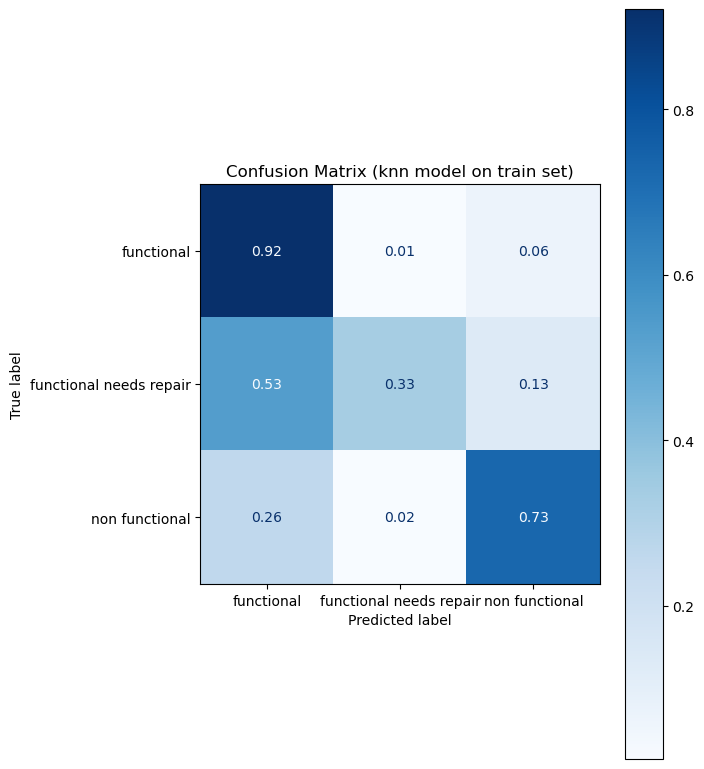

----------------------------------------------------------------------------------------------------
random_forest Results:
Accuracy: 0.9317
F1: 0.931
                         precision    recall  f1-score   support

             functional       0.93      0.95      0.94     32259
functional needs repair       0.85      0.77      0.81      4317
         non functional       0.94      0.93      0.94     22824

               accuracy                           0.93     59400
              macro avg       0.91      0.89      0.90     59400
           weighted avg       0.93      0.93      0.93     59400



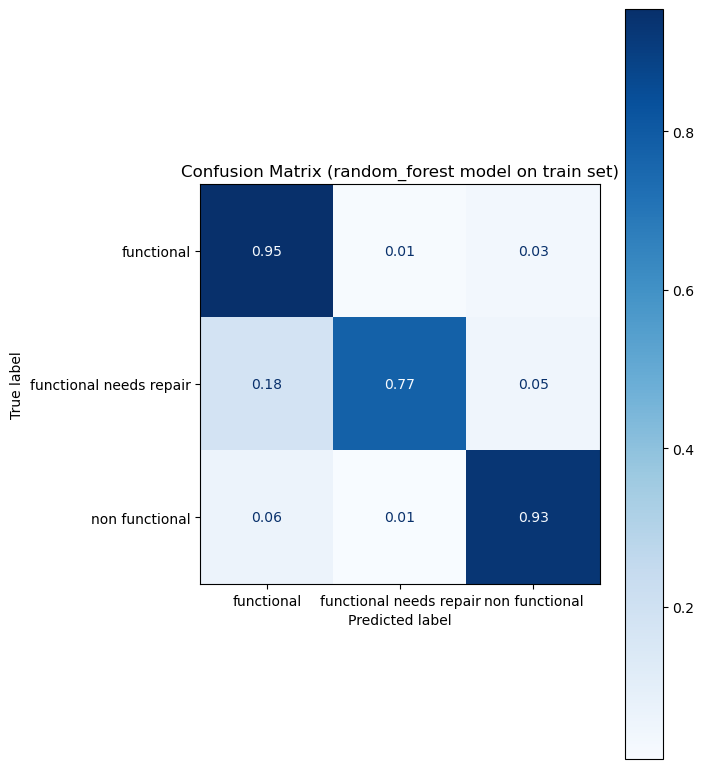

In [21]:
f_test = f_test[features + ['id']]
f_test['district_code'] = f_test['district_code'].astype(str)
f_test = pd.get_dummies(f_test)

# Class labels
l_class = le.classes_

# Evaluate models on full training data
for name, model in best_models.items():
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average = 'weighted')
    report = classification_report(y, y_pred, target_names = l_class)

    print(name, 'Results:')
    print('Accuracy:', round(acc, 4))
    print('F1:', round(f1, 3))
    print(report)

    cm = confusion_matrix(y, y_pred, normalize = 'true')
    fig, ax = plt.subplots(figsize = (7.2, 7.8))
    cm_disp = ConfusionMatrixDisplay(cm, display_labels = l_class)
    cm_disp.plot(ax = ax, cmap='Blues', values_format='.2f') # Show percentages with 2 decimals
    plt.title('Confusion Matrix (' + name + ' model on train set)')
    plt.tight_layout()
    plt.show()

    if name != 'random_forest':
        print('-' * 100)
    else:
        y_pred = le.inverse_transform(model.predict(f_test.drop(columns = ['id'])))
        
        df_pred = pd.DataFrame({
            'id': f_test['id'],
            'status_group': y_pred
        })
        df_pred.to_csv('result.csv', index = False)
       


## Conclusion

In this project, we explored pump functionality classification using real-world waterpoint data from Tanzania. Through careful exploratory analysis and deliberate feature engineering, we identified a focused set of physical, geographical, and economical indicators that best describe a waterpoint's operational status.

Rather than rely on automated dimensionality reduction, we reduced noise by selecting informative and interpretable features. Using cross-validated grid search, we trained and optimized both K-Nearest Neighbors and Random Forest classifiers, achieving strong accuracy and stable evaluation scores.

This approach balances rigor and practicality, showing that carefully chosen features — even in a noisy dataset — can yield reliable, actionable models.
